In [892]:
import pandas as pd 
import numpy as np
import scipy.stats as sts
import itertools as it

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# Домашнее задание по математической статистике
## Шансков Максим, БЭК213

## Задача 1
### a)
Вероятнось, что приедет конкретный таксист = $\frac{1}{n}$ <br>
Вероятность, что на 10 заказе один из таксистов повторился - $$\frac{n-1}{n} * \frac{n-2}{n} * ... * \frac{n-8}{n} * \frac{9}{n} $$

Выпишем функцию вероятности, матожидания и правдободобия.

In [893]:
def P_1(n, k):
    """
    Вероятность встретить одного из n таксистов дважды в k поездках 
    n(int) - количество таксистов
    k(int) - количество поездок
    """
    
    ans = np.prod((np.ones(k - 2) * n - np.arange(1, k-1))/n) * (k - 1)/n
    return ans

def E_1(n):
    """
    Матожидание числа поездок до первого повтора 
    n(int) - количество таксистов 
    """
    vec_k = np.arange(2, n+2) #K может быть в интервале от 2 до n+1
    P_v = np.vectorize(P_1)
    Vec_p = P_v(n, vec_k)
    return sum(vec_k * Vec_p)


def L_1(k, n_space):
    """
    Функция правдоподобия (для одного наблюдения)
    k(int) - наблюдаемое количество таксистов до повтора
    n_space(np.array) - множество n, для которых рассчитывается функция
    """
    Vec_p = np.vectorize(P_1)
    res = Vec_p(n_space, k)
    return res

ML - оценка: 42


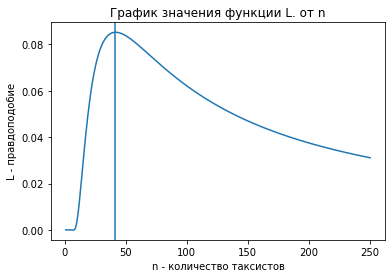

In [894]:
n_space = np.arange(1, 251) #Просто ряд разных n

plt.plot(n_space, L_1(10, n_space));
plt.title('График значения функции L. от n')
plt.xlabel('n - количество таксистов')
plt.ylabel('L - правдоподобие')
print(f'ML - оценка: {np.argmax(L_1(10, n_space)) + 1}') #единицу добавляем т.к. счет с 0
plt.axvline(np.argmax(L_1(10, n_space)))

### б)

Оценка методом моментов: 55


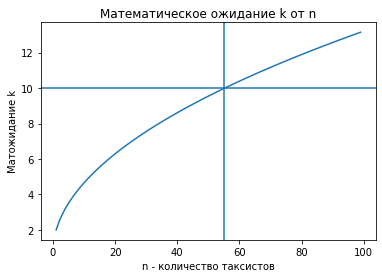

In [895]:
n_space = np.arange(1, 100)
E_vect = np.vectorize(E_1)
E_space = E_vect(n_space)

### Оценка методом моментов:
MM = np.argmin(np.absolute(E_space - 10)) + 1 #k = 10, +1 добавляем т.к нумерация с 0
print(f'Оценка методом моментов: {MM}')

plt.axhline(y = 10)
plt.axvline(x = MM)
plt.plot(n_space, E_space);
plt.title('Математическое ожидание k от n')
plt.xlabel('n - количество таксистов')
plt.ylabel('Матожидание k');

###  в)
Сделаем симуляцию десяти тысяч вызовов такси до первого повтора.

In [896]:
np.random.seed(1)
n = 100
taxis = np.arange(1, n)
k_obs = np.array([])
for i in range(1, 10001):
    nrides = 1
    rides = []
    taxi = np.random.choice(taxis) 
    while np.isin(taxi, rides) == False:
        rides.append(taxi)
        taxi = np.random.choice(taxis)
        nrides += 1
    k_obs = np.append(k_obs, nrides).astype(int)
    
k_obs

array([23,  3, 17, ..., 13,  5, 12])

В результате получаем 10^4 количеств поездок до повтора. Посмотрим на распределение.

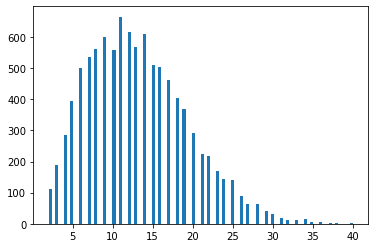

In [897]:
plt.hist(k_obs, bins = 100);

Для метода максимального правдоподобия прогоним функцию правдоподобия для каждого из 10^4 полученных <b>k</b> и возьмем среднее по оценкам.

In [898]:
ML_func = np.vectorize(L_1)
n_space = np.arange(1, 501) 
ML_res = ML_func(k_obs[:, np.newaxis], n_space) #массив 10^4 на 200, где каждая строка - результат работы функции L при полученном К

In [899]:
ML_arr = np.argmax(ML_res, axis = 1)
ML_arr += 1 #т.к мы начинали с n = 1, а счет идет с 0
ML_res = ML_arr.mean()
print(f'Оценка методом максимального правдоподобия: {ML_res}')

Оценка методом максимального правдоподобия: 94.2766


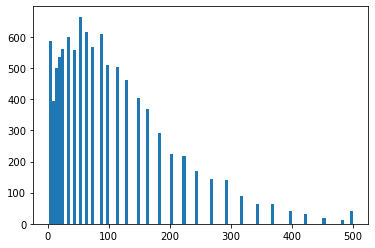

In [900]:
plt.hist(ML_arr, bins = 100);

<b>Метод моментов:</b>


In [901]:
MM_func = np.vectorize(E_1)
n_space = np.arange(1, 501)
MM_arr = MM_func(n_space)
MM_arr = np.absolute(k_obs[:, np.newaxis] - MM_arr)
MM_arr = np.argmin(MM_arr, axis = 1) + 1
MM_res = MM_arr.mean()
print(f'Оценка методом моментов: {MM_res}')

Оценка методом моментов: 121.8986


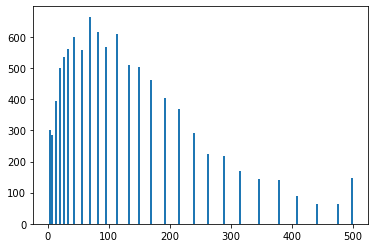

In [902]:
plt.hist(MM_arr, bins = 150);

In [903]:
result = pd.DataFrame({'Оценка': ('ML', 'MM'),
                       'Смещение': (abs(100 - ML_res), abs(100 - MM_res)), 'Дисперсия': (np.var(ML_arr), np.var(MM_arr)), 'Среднеквадратичная ошибка': (np.std(ML_arr), np.std(MM_arr))})
result.set_index("Оценка", inplace= True)
result

,Смещение,Дисперсия,Среднеквадратичная ошибка
Оценка,,,
ML,5.7234,8033.360892,89.629018
MM,21.8986,12350.195518,111.131434


## Задача 2
### а)
Аналогично первой задаче, попробуем выписать функцию вероятности, правдоподобия и матожидания. Однако в этом случае функция вероятности гораздо сложнее, так как нужно учесть все комбинации "неоригинальных" имен. Поэтому вероятность получаем, перебирая все комбинации.

In [904]:
def P_2(n, a, k):
    """
    Вероятность получить a имен в k кпоездках
    n(int) - количество уникальных имен у всех таксистов
    a(int) - количество уникальных имен в выборке
    k(int) - размер выборки
    """
    p=1
    for i in range(1, a):
        p *= ((n-i)/n)
    combs = it.combinations_with_replacement(np.arange(1, a+1), k - a)
    cnt = 0
    for comb in combs:
        mult = 1
        for i in range(k - a):
            mult *= comb[i]
        cnt += mult
    p *= (cnt/(n**(k - a)))
    return p

In [905]:
def L_2(n_space, a, k):
    """
    Функция правдоподобия (для одного наблюдения)
    n_space(np.array) - множество n, для которых рассчитывается функция
    a(int) - количество уникальных имен в выборке
    k(int) - размер выборки
    """
    Vec_p = np.vectorize(P_2)
    res = Vec_p(n_space, a, k)
    return res

def E_2(n, k):
    """
    Матожидание уникальных имен a для k таксистов
    n(int) - количество имен
    n(int) - количество таксистов
    """
    vec_a = np.arange(1, k+1) #a может быть в интервале от 2 до n
    P_v = np.vectorize(P_2)
    Vec_p = P_v(n, vec_a, k)
    return sum(vec_a * Vec_p)


ML - оценка: 8


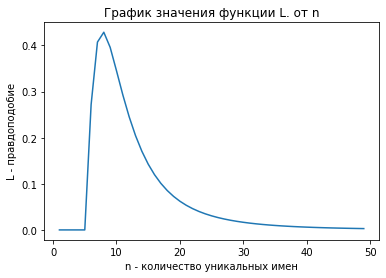

In [906]:
n_space = np.arange(1, 50)

plt.plot(n_space, L_2(n_space, 6, 10));
plt.title('График значения функции L. от n')
plt.xlabel('n - количество уникальных имен')
plt.ylabel('L - правдоподобие')
print(f'ML - оценка: {np.argmax(L_2(n_space, 6, 10)) + 1}') #единицу добавляем т.к. счет с 0

### б)

Оценка методом моментов: 8


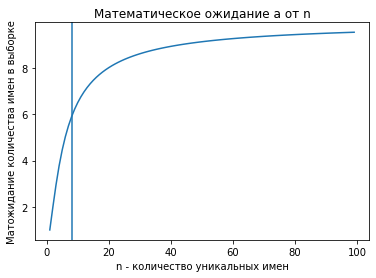

In [907]:
k = 10
a = 6
n_space = np.arange(1, 100)
E_vect = np.vectorize(E_2)
E_space = E_vect(n_space, k)

### Оценка методом моментов:
MM = np.argmin(np.absolute(E_space - a)) + 1
print(f'Оценка методом моментов: {MM}')

plt.axvline(x = MM);
plt.plot(n_space, E_space);
plt.title('Математическое ожидание a от n')
plt.xlabel('n - количество уникальных имен')
plt.ylabel('Матожидание количества имен в выборке');

### в)
Создаем 10^4 симуляций вызова 10 такси.

In [908]:
np.random.seed(1)
n = 20
k = 10
names = np.arange(n)
a_obs = np.array([])
for i in range(1, 10001):
    a_inride = 0
    names_obs = []
    for i in range(k):
        name = np.random.choice(names)
        if name not in names_obs:
            names_obs.append(name)
            a_inride += 1
    a_obs = np.append(a_obs, a_inride).astype(int)
a_obs

array([8, 9, 8, ..., 9, 8, 9])

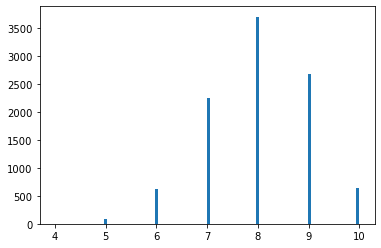

In [909]:
plt.hist(a_obs, bins = 100);

In [910]:
n_space = np.arange(1, 101) 
ML_func = np.vectorize(L_2)
ML_res = ML_func(n_space, a_obs[:, np.newaxis], 10)
#ML_res -  массив 10^4 на 100, где каждая строка - результат работы функции L при полученном К
ML_arr = np.argmax(ML_res, axis = 1)
ML_arr += 1 #т.к мы начинали с n = 1, а счет идет с 0
ML_res = ML_arr.mean()
print(f'Оценка методом максимального правдоподобия: {ML_res}')

Оценка методом максимального правдоподобия: 28.0006


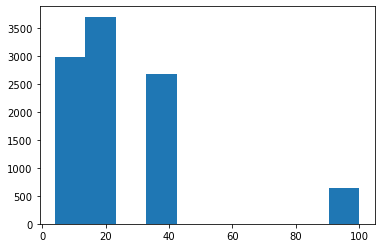

In [911]:
plt.hist(ML_arr, bins = 10);

In [912]:
MM_func = np.vectorize(E_2)
k = 10
n_space = np.arange(1, 100)
MM_arr = MM_func(n_space, 10)
MM_arr = np.absolute(a_obs[:, np.newaxis] - MM_arr)
MM_arr = (np.argmin(MM_arr, axis = 1) + 1)
MM_res = MM_arr.mean()
print(f'Оценка методом моментов: {MM_res}')

Оценка методом моментов: 28.3149


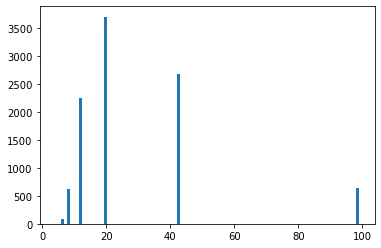

In [913]:
plt.hist(MM_arr, bins = 100);

In [914]:
result = pd.DataFrame({'Оценка': ('ML', 'MM'),
                       'Смещение': (abs(20 - ML_res), abs(20 - MM_res)), 'Дисперсия': (np.var(ML_arr), np.var(MM_arr)), 'Среднеквадратичная ошибка': (np.std(ML_arr), np.std(MM_arr))})
result.set_index("Оценка", inplace= True)
result

,Смещение,Дисперсия,Среднеквадратичная ошибка
Оценка,,,
ML,8.0006,504.620400,22.463757
MM,8.3149,488.608938,22.104500


Обе оценки оказались сильно смещенными. Это объясняется тем, что для некоторых насимулированных результатов оценка получалась при максимальном <b>n</b>, т.е. 100.

## Задача 3
### a)
Сразу нагенерируем 10^4 на 20 случайных экспоненциальных значений.

In [915]:
np.random.seed(1)
exp_gen = np.random.exponential(1, size=(10**4, 20))

<b>Асимптотический нормальный интервал</b>

In [916]:
z_stat = (np.mean(exp_gen, axis = 1) - 1) / np.sqrt(np.var(exp_gen, axis = 1) /20)
z_stat = np.where((z_stat > sts.norm(loc = 0, scale = 1).ppf(0.025)) & (z_stat < sts.norm(loc = 0, scale = 1).ppf(0.975)),
                  1, 0)
z_stat.mean()

0.8985

<b>Наивный бутстрап</b>

In [917]:
##NAIVE BOOTSTRAP
def NBoot(sample, mu_0):
    boot_sample = np.random.choice(sample, size = (10 ** 4, len(sample)))
    mean_sample = np.mean(boot_sample, axis = 1)
    result = np.mean(np.where((np.percentile(mean_sample, 2.5) <= mu_0) & (np.percentile(mean_sample, 97.5) >= mu_0), 1, 0))
    return result

In [918]:
nboot_res = np.apply_along_axis(NBoot, mu_0 = 1, axis=1, arr=exp_gen)
nboot_res.mean()

0.9063

<b>Бутстрап t-статистики</b>

In [919]:
## T-BOOTSTRAP
def TBoot(sample, mu_0):
    boot_sample = np.random.choice(sample, size = (10 ** 4, len(sample)))
    mean_sample = np.mean(boot_sample, axis = 1)
    mean_orig = np.mean(sample)
    se = np.std(boot_sample, axis=1, ddof=1)/np.sqrt(len(sample))
    t_test = (mean_sample - mean_orig)/se
    left = mean_orig - np.percentile(t_test, 97.5) * (np.std(sample, ddof = 1)) / np.sqrt(len(sample))
    right = mean_orig - np.percentile(t_test, 2.5) * (np.std(sample, ddof = 1)) / np.sqrt(len(sample))
    result = np.mean(np.where((left <= mu_0) & (right >= mu_0), 1, 0))
    return result

In [920]:
tboot_res = np.apply_along_axis(TBoot, mu_0 = 1, axis=1, arr=exp_gen)
tboot_res.mean()

0.9485

### б)
Аналогично первому пункту

In [921]:
np.random.seed(1)
t_gen = np.random.standard_t(df = 3, size=(10**4,20))

In [922]:
z_stat_t = (np.mean(t_gen, axis = 1)) / np.sqrt(np.var(t_gen, axis = 1) / len(t_gen[0]))
z_stat_t = np.where((z_stat_t > sts.norm(loc = 0, scale = 1).ppf(0.025)) & (z_stat_t < sts.norm(loc = 0, scale = 1).ppf(0.975)),
                  1, 0)
z_stat_t.mean()

0.9335

In [923]:
nboot_res_t = np.apply_along_axis(NBoot, mu_0 = 0, axis=1, arr=t_gen)
nboot_res_t.mean()

0.9173

In [924]:
tboot_res_t = np.apply_along_axis(TBoot, mu_0 = 0, axis=1, arr=t_gen)
tboot_res_t.mean()

0.9242

In [925]:
result = pd.DataFrame({'Распределение': ('Exp(1)', 't(3)'),
                       'Z-test': (z_stat.mean(), z_stat_t.mean()), 'Naive Bootstrap': (nboot_res.mean(), nboot_res_t.mean()), 'T-Bootstrap': (tboot_res.mean(), tboot_res_t.mean())})
result.set_index("Распределение", inplace= True)
result

,Z-test,Naive Bootstrap,T-Bootstrap
Распределение,,,
Exp(1),0.8985,0.9063,0.9485
t(3),0.9335,0.9173,0.9242


## Задача 4
Подгрузим результаты и уберем лишнее

In [926]:
df = pd.read_excel('22-23_hse_probability.xlsx', sheet_name="Exam")
df.drop(df[df["Last name"].isna()].index, inplace=True)
df = df[["Last name", "Name", "Unnamed: 74"]]
df = df.drop(df[df["Unnamed: 74"] == "неявка"].index)
df.columns = ["Last name", "Name", "Score"]
df

,Last name,Name,Score
5,Репенкова,Полина Александровна,16
7,Сафина,Алия Линаровна,19
8,Сидоров,Иван Максимович,26
9,Солоухин,Иван Владимирович,21
10,Старощук,Богдан Павлович,22
...,...,...,...
328,Петрова,Марьяна Петровна,10
329,Полищук,Мария Вячеславовна,25
331,Савенкова,Софья Дмитриевна,4
332,Сенников,Александр -,19


In [927]:
df["F_letter"] = df["Last name"].astype(str).str[0]
df["glas_letter"] = np.where(np.isin(df["F_letter"],["А","Е","Ё","И","О","У","Ы","Э","Ю","Я"]), 1, 0)

### а)
Сделаем функцию теста Уэлча

In [928]:
def welch_test(x, y):
    x_mean = x.mean()
    y_mean = y.mean()
    diff_mean = x_mean - y_mean
    var_x_est = x.var() / len(x)
    var_y_est = y.var() / len(y)
    t_stat = diff_mean / np.sqrt(var_x_est + var_y_est)
    
    dof = (var_x_est + var_y_est) ** 2 / ( var_x_est ** 2 / (len(x) - 1) +  var_y_est ** 2 / (len(y) - 1))
    
    left = diff_mean + sts.t.ppf(0.025, dof) * np.sqrt(var_x_est + var_y_est)
    right = diff_mean + sts.t.ppf(0.975, dof) * np.sqrt(var_x_est + var_y_est)
    
    res = ((left <= 0) & (right >= 0) == True)
    p_value = 2 * (min(sts.t.cdf(t_stat, dof), 1 - sts.t.cdf(t_stat, dof)))
    return res, p_value

In [929]:
print(f'Результат проверки нулевой гипотезы: {welch_test(df[df["glas_letter"] == 1]["Score"], df[df["glas_letter"] == 0]["Score"])[0]}')
print(f'P-value: {welch_test(df[df["glas_letter"] == 1]["Score"], df[df["glas_letter"] == 0]["Score"])[1]}')

Результат проверки нулевой гипотезы: True
P-value: 0.3909901940797269


Нулевая гипотеза не отвергается, ожидаемые результаты для обладателей фамилий на гласную и согласную равны, p-value очень большой.
Можно сравнить результат с готовым тестом Уэлча из SciPy.

In [930]:
scipy_welch = sts.ttest_ind(df[df["glas_letter"] == 1]["Score"], df[df["glas_letter"] == 0]["Score"], equal_var=False, alternative='two-sided')
scipy_welch

Ttest_indResult(statistic=-0.8646536949457262, pvalue=0.390990194079727)

Получилось то же самое, это радует.
### б)

In [931]:
##NAIVE BOOTSTRAP
def NBoot_4(sample_x, sample_y):
    sample_dif = np.mean(sample_x) - np.mean(sample_y)
    boot_sample_x = np.random.choice(sample_x, size = (10 ** 4, len(sample_x)))
    boot_sample_y = np.random.choice(sample_y, size = (10 ** 4, len(sample_y)))
    boot_mean_x = np.mean(boot_sample_x, axis = 1)
    boot_mean_y = np.mean(boot_sample_y, axis = 1)
    
    dif = boot_mean_x - boot_mean_y - sample_dif
    
    result = np.mean(np.where((np.percentile(dif, 2.5) <= 0) & (np.percentile(dif, 97.5) >= 0), 1, 0))
    p_value = 2 * np.min([np.mean((sample_dif <= dif)), 1 - np.mean((sample_dif <= dif))])
    return result, p_value

In [932]:
np.random.seed(5)
print(f'Результат проверки нулевой гипотезы: {NBoot_4(df[df["glas_letter"] == 1]["Score"], df[df["glas_letter"] == 0]["Score"])[0]}')
print(f'P-value: {NBoot_4(df[df["glas_letter"] == 1]["Score"], df[df["glas_letter"] == 0]["Score"])[1]}')

Результат проверки нулевой гипотезы: 1.0
P-value: 0.3777999999999999


При $\alpha = 5$% нулевая гипотеза не отвергается
### в)

In [933]:
def TBoot_4(sample_x, sample_y):
    
    sample_dif = np.mean(sample_x) - np.mean(sample_y)
    
    boot_sample_x = np.random.choice(sample_x, size = (10 ** 4, len(sample_x)))
    boot_sample_y = np.random.choice(sample_y, size = (10 ** 4, len(sample_y)))
    boot_mean_x = np.mean(boot_sample_x, axis = 1)
    boot_mean_y = np.mean(boot_sample_y, axis = 1)
    
    dif = boot_mean_x - boot_mean_y - mean_sample
    
    se_sample = np.sqrt(np.var(sample_x, ddof = 1) / len(sample_x) + np.var(sample_y, ddof = 1) / len(sample_y))
    se_boot = np.sqrt(np.var(boot_mean_x, ddof = 1) / len(sample_x) + np.var(boot_mean_y, ddof = 1) / len(sample_y))
    t_test = (dif - sample_dif) / se_boot
    t_sample = sample_dif / se_sample
      
    left = sample_dif - np.percentile(t_test, 97.5) * (np.std(sample, ddof = 1)) / np.sqrt(len(sample))
    right = sample_dif - np.percentile(t_test, 2.5) * (np.std(sample, ddof = 1)) / np.sqrt(len(sample))
    
    result = np.mean(np.where((left <= 0) & (right >= 0), 1, 0))
    p_value = 2 * min((t_test <= t_sample).sum() / len(t_test), (1 - (t_test <= t_sample)).sum() / len(t_test))
    return result, p_value

In [934]:
np.random.seed(5)
print(f'Результат проверки нулевой гипотезы: {TBoot_4(df[df["glas_letter"] == 1]["Score"], df[df["glas_letter"] == 0]["Score"])[0]}')
print(f'P-value: {TBoot_4(df[df["glas_letter"] == 1]["Score"], df[df["glas_letter"] == 0]["Score"])[1]}')

Результат проверки нулевой гипотезы: 1.0
P-value: 0.4994


При $\alpha = 5$% нулевая гипотеза не отвергается
## Задача 6

In [943]:
df1 = pd.read_excel('22-23_hse_probability.xlsx', sheet_name="Exam")
df1.drop(df1[df1["Last name"].isna()].index, inplace=True)
df1["Len"] = df1["Last name"].str.len()
df1 = df1[["Len", "Unnamed: 74"]]
df1 = df1.drop(df1[df1["Unnamed: 74"] == "неявка"].index)
df1.columns = ["Len", "Score"]
df1 = df1.astype(int)

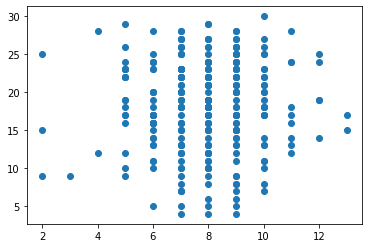

In [946]:
plt.scatter(x = df1["Len"], y = df1["Score"])

Значительной корреляции не видно. Тем не менее, вычислим <br>
$\beta$ в $E(Y_i) = \beta * F_i$
Для этого возьмем матожидание от обеих частей: $E(E(Y)) = E(Y) = \beta * E(F) \to \beta = \frac{E(Y)}{E(F)}$ <br>
$\hat E(F) = \overline{F}, \hat E(Y) = \overline{Y}$

In [947]:
beta = df1["Score"].mean() / df1["Len"].mean()
corr = np.corrcoef(df1["Len"], df1["Score"])[0][1]
print("Оценка беты:", beta)
print("Выборочная корреляция:", corr)

Оценка беты: 2.3109965635738834
Выборочная корреляция: 0.03332720342446381


### б)

In [948]:
np.random.seed(1)
cor_perm = np.array([])
for i in range(10**4):
    permut = np.random.permutation(df1["Score"])
    cor_perm = np.append(cor_perm, np.corrcoef(permut, df1["Len"])[0][1])
p_value = 2 * min(1 - ((cor_perm <= 0).sum())/len(cor_perm), ((cor_perm <= 0).sum())/len(cor_perm))
p_value

0.9902

При такой p-value нулевая гипотеза не отвергается никогда. Да здравствует равенство длиннофамильных и короткофамильных!

## Задача 7
Не очень сложная задачка на условную вероятность, но даже там пришлось подталкивать.
https://chat.openai.com/share/402f1268-776b-44ca-9aa8-9be02d41d955

## Задача 8
Канал с прекрасными визуальными объяснениями математики (и немного физики с информатикой)
https://www.youtube.com/@3blue1brown